# Crossmatching SExtractor Catalog with 2MASS

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.io.fits as fits
from astropy.io import ascii
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.wcs import WCS
from astropy import coordinates as coord
from astropy.table import QTable
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle

In [2]:
plt.style.use('default')

#### Image Information:

In [3]:
imageDataFile = 'stack_fs359_fid722_q2.fits.sq0.fits'
imageData = fits.getdata(imageDataFile)
imageHeader = fits.getheader(imageDataFile)

In [4]:
imageData.shape,imageHeader

((1064, 1064),
 SIMPLE  =                    T / conforms to FITS standard                      
 BITPIX  =                    8 / array data type                                
 NAXIS   =                    0 / number of array dimensions                     
 EXTEND  =                    T                                                  
 STACKID =               448396                                                  
 QUADPOS =                    2                                                  
 NIGHTID =                  629                                                  
 HIERARCH quadid_beg = 3634062                                                   
 HIERARCH quadid_end = 3634090                                                   
 NUMQUADS=                    8                                                  
 EXPTIME =            71.262912                                                  
 DATEBEG = '2020-06-22 07:48:41.478000'                                          
 

#### Determining Image Size:

In [5]:
pixelScale = 8.7/2 #arcsec
width = imageData.shape[0]
height = imageData.shape[1]
sizeWidth = (pixelScale/3600)*width
sizeHeight = (pixelScale/3600)*height
print(f'The size of the image is {(sizeWidth):.4f} x {(sizeHeight):.4f} degrees.')

The size of the image is 1.2857 x 1.2857 degrees.


#### Where is this image located?

In [6]:
import warnings
warnings.filterwarnings('ignore')
dataWCS = WCS(imageHeader)

In [7]:
dataWCS

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 220.54852980992  11.96488163122  
CRPIX : 1044.0  1044.0  
CD1_1 CD1_2  : 2.3789966467297e-05  0.001211402605241  
CD2_1 CD2_2  : 0.0012113816711632  -2.3474747733672e-05  
NAXIS : 0  0

In [8]:
# RA and DEC of the center of the image (degrees)
raCent = 220.54852980992
decCent = 11.96488163122

In [9]:
radius = (sizeWidth*np.sqrt(2))/2
print(f'{raCent} {decCent} {radius}')

220.54852980992 11.96488163122 0.9091036183455046


In [10]:
raMin = raCent - 532*(pixelScale/3600)
raMax = raCent + 532*(pixelScale/3600)
decMin = decCent - 532*(pixelScale/3600)
decMax = decCent + 532*(pixelScale/3600)

In [11]:
raMin,raMax,decMin,decMax

(219.90569647658668,
 221.19136314325334,
 11.322048297886667,
 12.607714964553335)

In [12]:
if round(raMax-raMin,4) == round(sizeWidth,4) and round(raMax-raMin,4) == round(sizeHeight,4):
    print('You did the RA calculation right!')
else:
    print('You suck!')

You did the RA calculation right!


In [13]:
if round(decMax-decMin,4) == round(sizeWidth,4) and round(decMax-decMin,4) == round(sizeHeight,4):
    print('You did the DEC calculation right!')
else:
    print('You suck!')

You did the DEC calculation right!


## Crossmatching

#### Reading in and making the data usable:

2MASS

In [14]:
twoMASS = ascii.read('twoMASS_for_stack_fs359.tsv')

In [15]:
twoMASS = twoMASS.to_pandas()

In [16]:
twoMASS.drop([0,1], axis = 0, inplace = True)

In [17]:
twoMASS.reset_index(inplace = True)

In [18]:
twoMASS.drop('index', axis = 1, inplace = True)

In [19]:
twoMASS.dtypes

_r           object
_RAJ2000     object
_DEJ2000     object
RAJ2000      object
DEJ2000      object
2MASS        object
Jmag         object
e_Jmag       object
Hmag         object
e_Hmag       object
Kmag         object
e_Kmag       object
Qflg         object
Rflg         object
Bflg         object
Cflg         object
Xflg         object
Aflg        float64
dtype: object

In [20]:
twoMASS['Jmag'] = twoMASS['Jmag'].astype(float)
twoMASS['_RAJ2000'] = twoMASS['_RAJ2000'].astype(float)
twoMASS['_DEJ2000'] = twoMASS['_DEJ2000'].astype(float)
twoMASS['RAJ2000'] = twoMASS['RAJ2000'].astype(float)
twoMASS['DEJ2000'] = twoMASS['DEJ2000'].astype(float)

In [21]:
# There's too many sources here, 2MASS is deeper than Gattini
# Filtering the results to what can be detected by Gattini
limitingMag = imageHeader['LIMMAGPSF'] # 5sigma 
queryMag = limitingMag - 0.5
queryMag
twoMASS = twoMASS.query(f'Jmag < {queryMag}')

In [22]:
len(twoMASS) # Much more reasonable

2016

In [23]:
twoMASS.head()

,_r,_RAJ2000,_DEJ2000,RAJ2000,DEJ2000,2MASS,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,Qflg,Rflg,Bflg,Cflg,Xflg,Aflg
9,0.039085,220.587849,11.971821,220.587849,11.971821,14422108+1158185,12.675,0.023,12.150,0.026,12.075,0.028,AAA,222,111,000,0,0.0
18,0.060931,220.550165,12.025792,220.550165,12.025792,14421203+1201328,13.482,0.025,13.155,0.029,13.169,0.032,AAA,222,111,000,0,0.0
26,0.068486,220.492863,11.923358,220.492863,11.923358,14415828+1155240,13.667,0.030,13.199,0.031,13.182,0.040,AAA,222,111,000,0,0.0
32,0.076985,220.469869,11.962639,220.469869,11.962639,14415276+1157455,11.682,0.026,11.342,0.025,11.243,0.023,AAA,222,111,000,0,0.0
33,0.079067,220.620364,11.928652,220.620364,11.928652,14422888+1155431,12.511,0.023,11.939,0.026,11.745,0.023,AAA,222,111,000,0,0.0


SExtractor

In [24]:
sexCat = ascii.read('SExtractor_test1.cat')
sexCat = sexCat.to_pandas()

In [25]:
sexCat.head()

,NUMBER,EXT_NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,X_IMAGE,Y_IMAGE,ALPHAWIN_J2000,DELTAWIN_J2000
0,1,1,23522.020,168.6695,-10.9287,0.0078,677.2875,43.1109,219.302317,11.541400
1,2,1,16460.610,158.5474,-10.5411,0.0105,901.9224,31.9956,219.292748,11.813595
2,3,1,70976.880,221.2643,-12.1278,0.0034,502.8295,32.0339,219.285446,11.330459
3,4,1,4055061.000,900.0878,-16.5200,0.0002,401.7319,16.2198,219.264029,11.208210
4,5,1,1197.572,90.8176,-7.6958,0.0824,349.7413,22.3033,219.271310,11.145611


#### Comparing SExtractor Catalog with 2MASS

(11.322048297886667, 12.607714964553335)

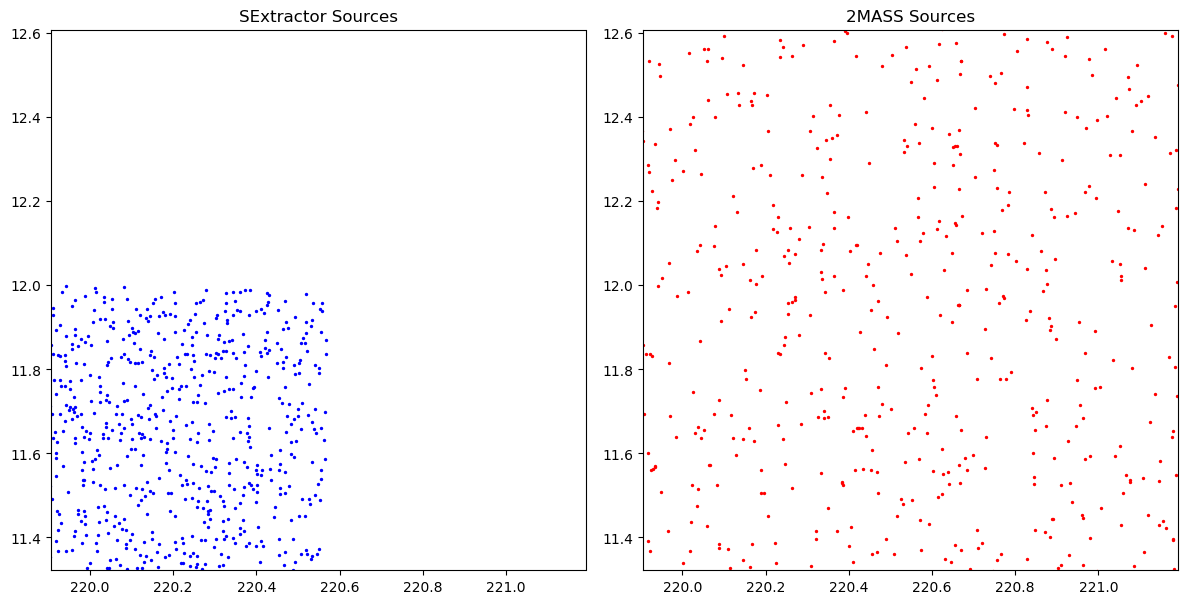

In [26]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
fig.tight_layout()

ax[0].scatter(sexCat['ALPHAWIN_J2000'], sexCat['DELTAWIN_J2000'], s = 2, color = 'blue')
ax[0].set_title('SExtractor Sources')
ax[0].set_xlim(raMin,raMax)
ax[0].set_ylim(decMin,decMax)

ax[1].scatter(twoMASS['RAJ2000'], twoMASS['DEJ2000'], s = 2, color = 'red')
ax[1].set_title('2MASS Sources')
ax[1].set_xlim(raMin,raMax)
ax[1].set_ylim(decMin,decMax)

In [27]:
# Iguess I did mess up the RA and DEC calculations
sexRaMin = sexCat['ALPHAWIN_J2000'].min()
sexRaMax = sexCat['ALPHAWIN_J2000'].max()
sexDecMin = sexCat['DELTAWIN_J2000'].min() 
sexDecMax = sexCat['DELTAWIN_J2000'].max()

In [28]:
twoMASS = twoMASS.query(f'RAJ2000 >= {sexRaMin} and RAJ2000 <= {sexRaMax}')
twoMASS = twoMASS.query(f'DEJ2000>= {sexDecMin} and DEJ2000 <= {sexDecMax}')

In [29]:
print(f'There are {len(twoMASS)} 2MASS sources in this region with <15 J-band magnitudes.')

There are 525 2MASS sources in this region with <15 J-band magnitudes.


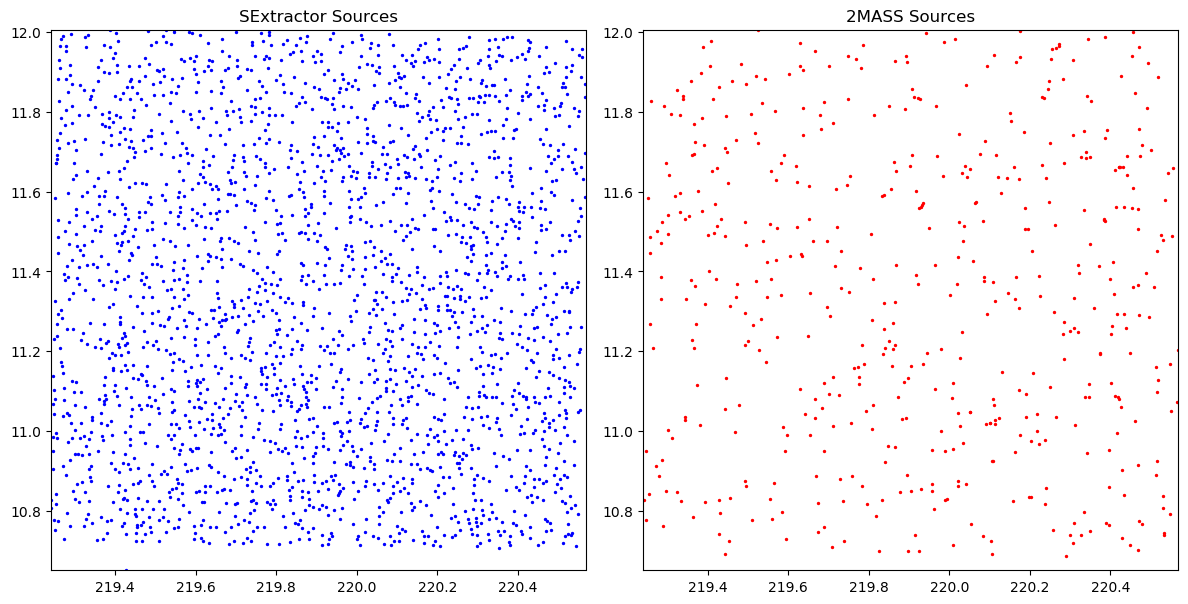

In [30]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
fig.tight_layout()

ax[0].scatter(sexCat['ALPHAWIN_J2000'], sexCat['DELTAWIN_J2000'], s = 2, color = 'blue')
ax[0].set_title('SExtractor Sources')
ax[0].set_xlim(sexRaMin,sexRaMax)
ax[0].set_ylim(sexDecMin,sexDecMax)

ax[1].scatter(twoMASS['RAJ2000'], twoMASS['DEJ2000'], s = 2, color = 'red')
ax[1].set_title('2MASS Sources')
ax[1].set_xlim(sexRaMin,sexRaMax)
ax[1].set_ylim(sexDecMin,sexDecMax);

#### Crossmatching

In [31]:
twoMASSRas = twoMASS.RAJ2000.values*u.degree
twoMASSDecs = twoMASS.DEJ2000.values*u.degree
sexCatRas = sexCat.ALPHAWIN_J2000*u.degree
sexCatDecs = sexCat.DELTAWIN_J2000*u.degree

twoMASSCoords = SkyCoord(ra=twoMASSRas, dec=twoMASSDecs)
sexCatCoords = SkyCoord(ra=sexCatRas, dec=sexCatDecs)
idxRef, d2d, d3d = twoMASSCoords.match_to_catalog_sky(sexCatCoords)

In [32]:
matches = sexCatCoords[idxRef]

In [33]:
max_sep = 1.0 * u.arcsec
sep_constraint = d2d < max_sep
twoMassCoords_matches = twoMASSCoords[sep_constraint]
sexCatCoords_matches = sexCatCoords[idxRef[sep_constraint]]

#### Results of the Crossmatch

In [34]:
print(f'SExtractor Sources: {len(sexCat)}\n2MASS Sources: {len(twoMASS)}\nMatches: {len(sexCatCoords_matches)}')

SExtractor Sources: 2360
2MASS Sources: 525
Matches: 320


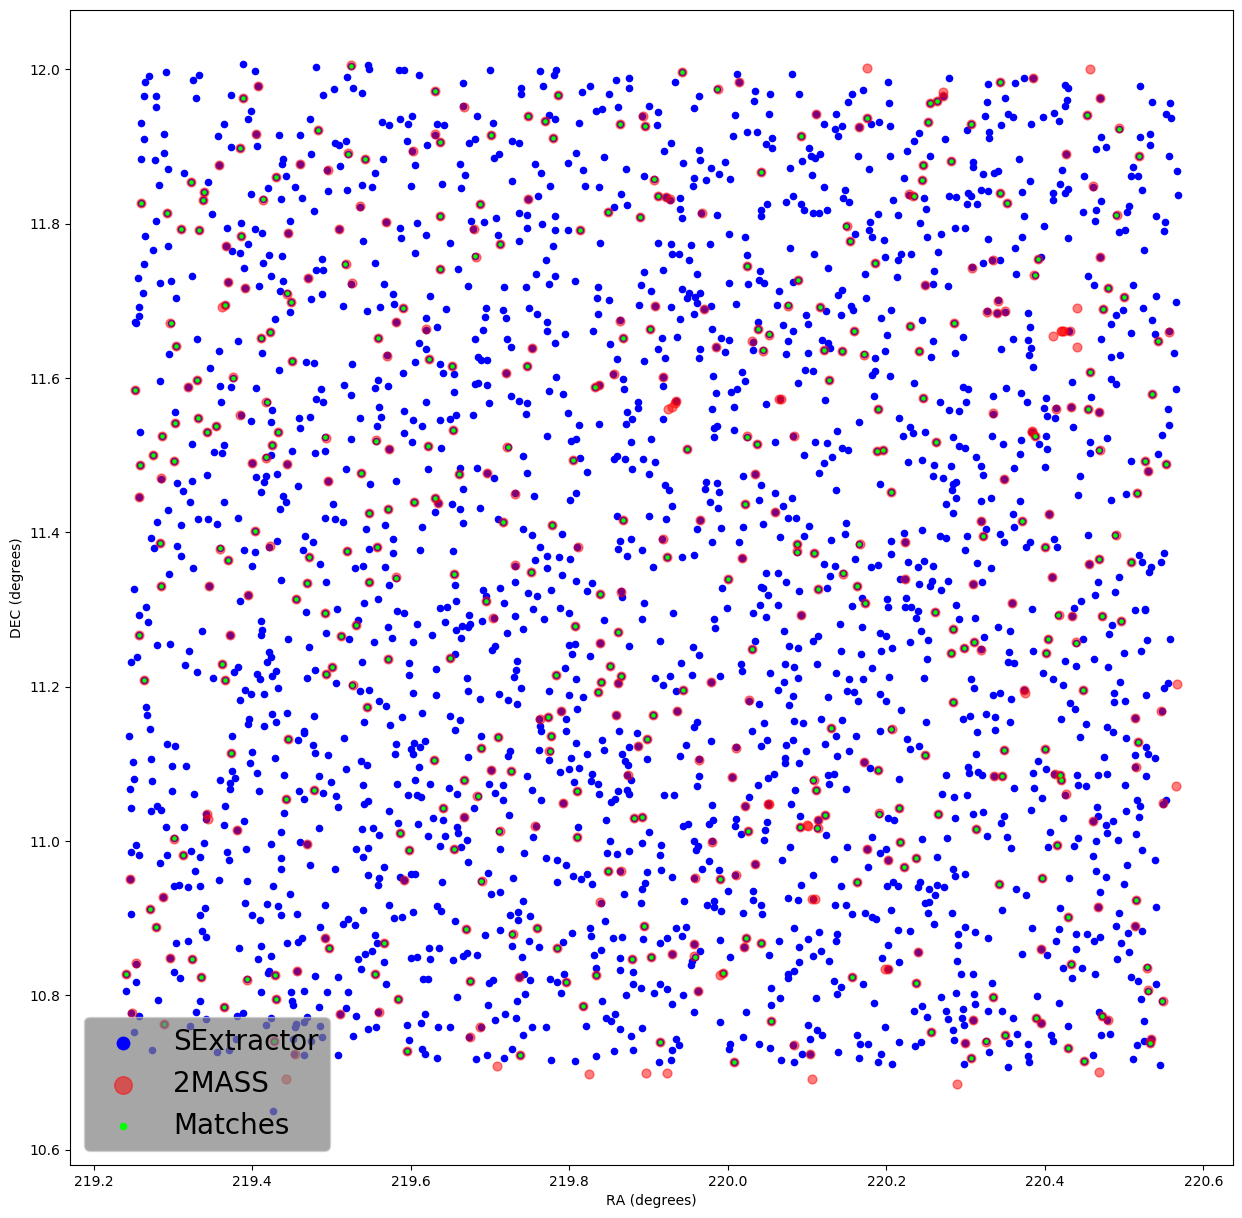

In [35]:
plt.figure(figsize = (15,15))
plt.scatter(sexCat['ALPHAWIN_J2000'], sexCat['DELTAWIN_J2000'], s = 20, c = 'blue', label = 'SExtractor')
plt.scatter(twoMASS['RAJ2000'], twoMASS['DEJ2000'], s = 40, c = 'red', alpha = 0.5, label = '2MASS')
plt.scatter(sexCatCoords_matches.ra,sexCatCoords_matches.dec, s= 5, color = 'lime', alpha = 1, label = 'Matches')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.legend(prop={'size': 20}, facecolor = 'gray', framealpha = 0.7, markerscale = 2.0);


In [36]:
dist2D = (d2d).value

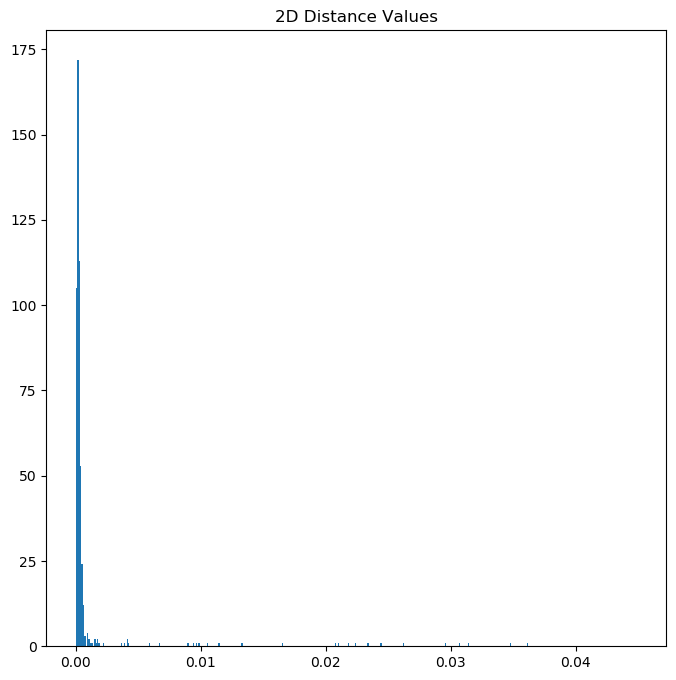

In [37]:
plt.figure(figsize = (8,8))
plt.title('2D Distance Values')
plt.hist(dist2D, bins = 400, range = (-0.0001,0.045));

In [38]:
sexCat.head()

,NUMBER,EXT_NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,X_IMAGE,Y_IMAGE,ALPHAWIN_J2000,DELTAWIN_J2000
0,1,1,23522.020,168.6695,-10.9287,0.0078,677.2875,43.1109,219.302317,11.541400
1,2,1,16460.610,158.5474,-10.5411,0.0105,901.9224,31.9956,219.292748,11.813595
2,3,1,70976.880,221.2643,-12.1278,0.0034,502.8295,32.0339,219.285446,11.330459
3,4,1,4055061.000,900.0878,-16.5200,0.0002,401.7319,16.2198,219.264029,11.208210
4,5,1,1197.572,90.8176,-7.6958,0.0824,349.7413,22.3033,219.271310,11.145611


### Narrowing SExtractor Catalog

In [39]:
sexCat2 = ascii.read('SExtractor_test2.cat')
sexCat2 = sexCat2.to_pandas()

In [40]:
sexCat2.head()

,NUMBER,SNR_WIN,EXT_NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,X_IMAGE,Y_IMAGE,ALPHAWIN_J2000,DELTAWIN_J2000,FLAGS,FWHM_IMAGE,ELONGATION
0,1,223.40,1,23522.020,168.6695,-10.9287,0.0078,677.2875,43.1109,219.302317,11.541400,0,2.47,1.090
1,2,155.70,1,16460.610,158.5474,-10.5411,0.0105,901.9224,31.9956,219.292748,11.813595,0,3.10,1.167
2,3,493.30,1,70976.880,221.2643,-12.1278,0.0034,502.8295,32.0339,219.285446,11.330459,0,3.33,1.065
3,4,4818.00,1,4055061.000,900.0878,-16.5200,0.0002,401.7319,16.2198,219.264029,11.208210,12,3.87,1.042
4,5,12.46,1,1197.572,90.8176,-7.6958,0.0824,349.7413,22.3033,219.271310,11.145611,0,8.26,1.870


In [41]:
sexCat2 = sexCat2.query('SNR_WIN >= 10') # Signal to Noise Ratio

In [42]:
sexCat2 = sexCat2.query('FLAGS < 4') # Only choosing sources with no bad flags

In [43]:
sexCat2 = sexCat2.query('FWHM_IMAGE > 1') # Eliminating hot pixels

In [44]:
sexCat2.reset_index(inplace = True)

In [45]:
len(sexCat2)

836

In [46]:
len(twoMASS)

525

In [47]:
twoMASSRas = twoMASS.RAJ2000.values*u.degree
twoMASSDecs = twoMASS.DEJ2000.values*u.degree
sexCat2Ras = sexCat2.ALPHAWIN_J2000*u.degree
sexCat2Decs = sexCat2.DELTAWIN_J2000*u.degree

twoMASSCoords = SkyCoord(ra=twoMASSRas, dec=twoMASSDecs)
sexCat2Coords = SkyCoord(ra=sexCat2Ras, dec=sexCat2Decs)
idxRef2, d2d2, d3d2 = twoMASSCoords.match_to_catalog_sky(sexCat2Coords)

In [48]:
matches2 = sexCat2Coords[idxRef2]

In [49]:
max_sep = 8 * u.arcsec
sep_constraint2 = d2d2 < max_sep
twoMassCoords_matches = twoMASSCoords[sep_constraint2]
sexCat2Coords_matches = sexCat2Coords[idxRef2[sep_constraint2]]

In [50]:
print(f'SExtractor Sources: {len(sexCat2)}\n2MASS Sources: {len(twoMASS)}\nMatches: {len(sexCat2Coords_matches)}')

SExtractor Sources: 836
2MASS Sources: 525
Matches: 476


In [51]:
badIdxList = idxRef2[sep_constraint2]
len(badIdxList)

476

In [52]:
#noMatch = sexCat2.loc[sexCat2.index.isin(badIdxList)]

In [54]:
noMatch = sexCat2.drop(badIdxList)

In [55]:
len(badIdxList)

476

In [56]:
len(noMatch) # Doesnt look like its working...

364

In [58]:
noMatch.head()

,index,NUMBER,SNR_WIN,EXT_NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,X_IMAGE,Y_IMAGE,ALPHAWIN_J2000,DELTAWIN_J2000,FLAGS,FWHM_IMAGE,ELONGATION
3,4,5,12.46,1,1197.5720,90.81760,-7.6958,0.0824,349.7413,22.3033,219.271310,11.145611,0,8.26,1.870
6,10,11,16.29,1,1555.4680,99.56004,-7.9797,0.0695,846.4716,9.1463,219.263303,11.747273,0,3.89,1.288
9,43,44,10.20,1,660.8122,67.35413,-7.0502,0.1107,862.6879,18.3712,219.275397,11.766379,0,4.66,1.654
11,48,49,10.31,1,688.8749,67.38017,-7.0954,0.1062,364.4968,19.8459,219.267858,11.163006,0,3.76,1.489
12,49,50,14.54,1,1056.9740,76.16312,-7.5602,0.0783,480.2280,16.9587,219.266440,11.303434,0,3.47,1.613


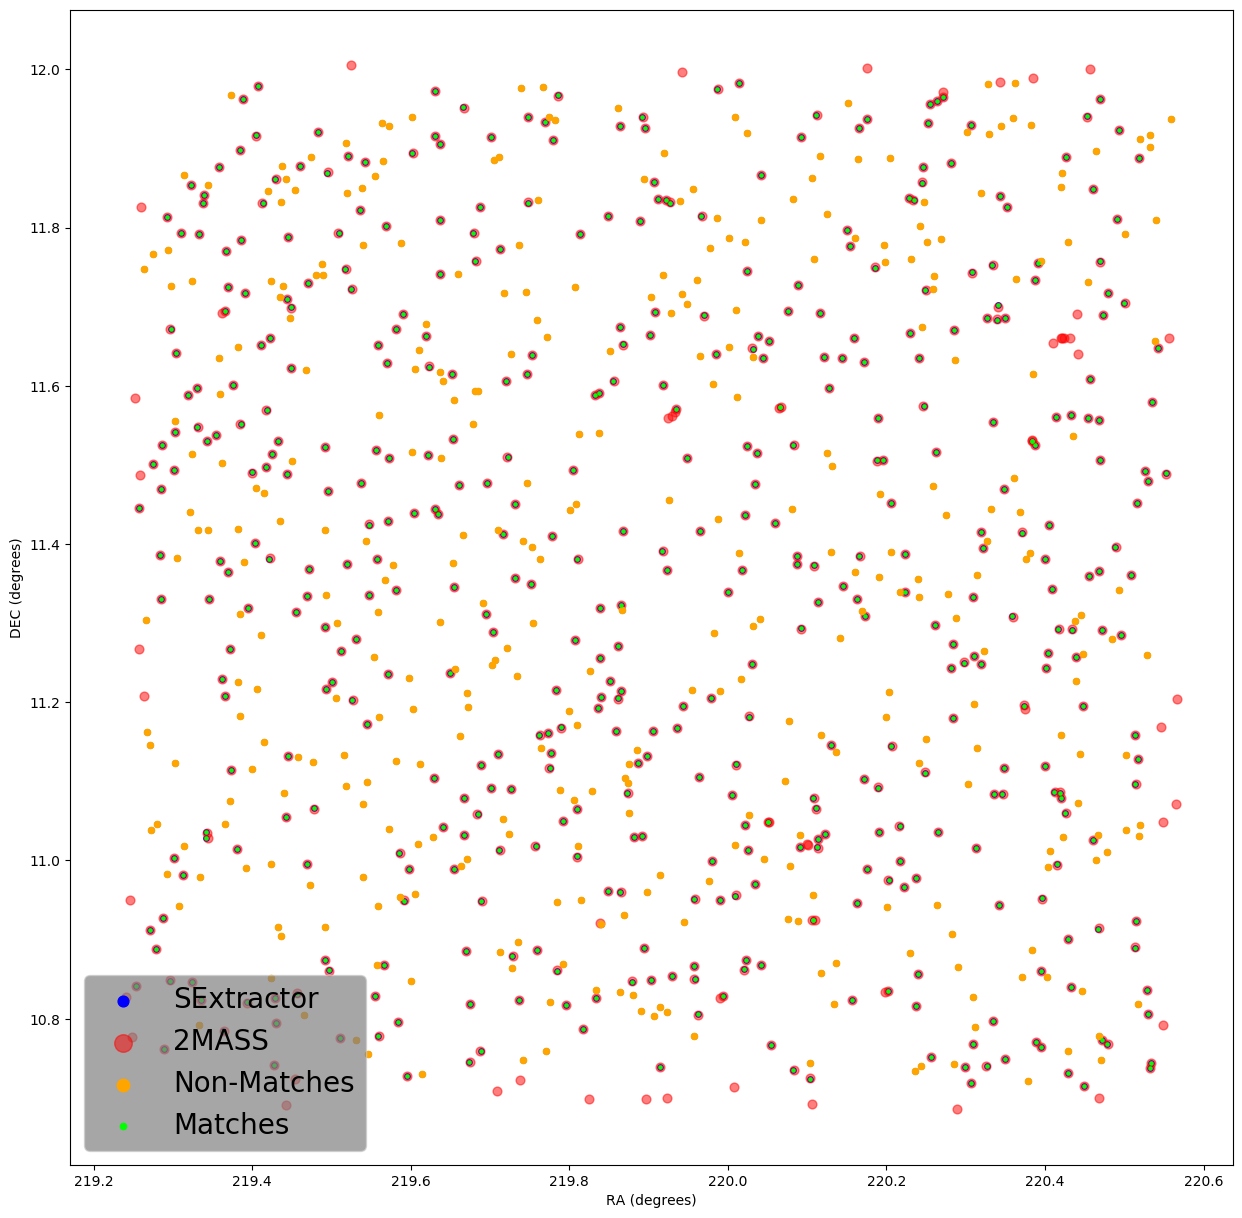

In [59]:
plt.figure(figsize = (15,15))
plt.scatter(sexCat2['ALPHAWIN_J2000'], sexCat2['DELTAWIN_J2000'], s = 15, c = 'blue', label = 'SExtractor')
plt.scatter(twoMASS['RAJ2000'], twoMASS['DEJ2000'], s = 40, c = 'red', alpha = 0.5, label = '2MASS')
plt.scatter(noMatch['ALPHAWIN_J2000'], noMatch['DELTAWIN_J2000'], s = 20, c = 'orange', label = 'Non-Matches')
plt.scatter(sexCat2Coords_matches.ra,sexCat2Coords_matches.dec, s= 5, color = 'lime', alpha = 1, label = 'Matches')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.legend(prop={'size': 20}, facecolor = 'gray', framealpha = 0.7, markerscale = 2.0);

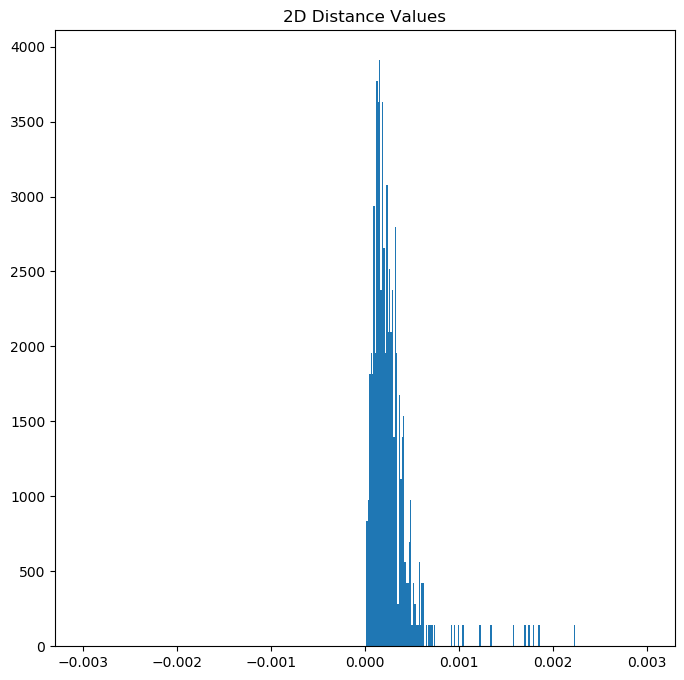

In [60]:
plt.figure(figsize = (8,8))
plt.title('2D Distance Values')
#plt.xticks(np.arange(-0.003,0.003,step = 0.001), fontsize = 10)
plt.hist(np.array(d2d2), bins = 400, range = (-0.003,0.003), normed = True);


### Examining the sources that did not match

In [61]:
sexCat2

,index,NUMBER,SNR_WIN,EXT_NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,X_IMAGE,Y_IMAGE,ALPHAWIN_J2000,DELTAWIN_J2000,FLAGS,FWHM_IMAGE,ELONGATION
0,0,1,223.40,1,23522.0200,168.66950,-10.9287,0.0078,677.2875,43.1109,219.302317,11.541400,0,2.47,1.090
1,1,2,155.70,1,16460.6100,158.54740,-10.5411,0.0105,901.9224,31.9956,219.292748,11.813595,0,3.10,1.167
2,2,3,493.30,1,70976.8800,221.26430,-12.1278,0.0034,502.8295,32.0339,219.285446,11.330459,0,3.33,1.065
3,4,5,12.46,1,1197.5720,90.81760,-7.6958,0.0824,349.7413,22.3033,219.271310,11.145611,0,8.26,1.870
4,5,6,95.00,1,8697.1540,129.91730,-9.8484,0.0162,643.3331,21.5190,219.275127,11.500789,0,3.40,1.052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,2346,2347,26.47,1,1942.9520,91.32912,-8.2212,0.0510,59.2061,1000.8766,220.471511,10.773196,3,2.89,1.435
832,2347,2348,18.36,1,1491.2440,93.21724,-7.9339,0.0679,62.8868,998.1665,220.468163,10.777783,3,3.59,1.533
833,2349,2350,56.26,1,5416.9290,132.97820,-9.3344,0.0267,574.1677,1005.1426,220.488952,11.396660,0,3.13,1.197
834,2356,2357,11.32,1,733.7997,73.18139,-7.1639,0.1083,477.4035,1003.3883,220.484669,11.279538,0,2.80,1.153


### Looking at the Signal to Noise Ratio

In [62]:
sexCat2 = ascii.read('SExtractor_test2.cat')
sexCat2 = sexCat2.to_pandas()

In [63]:
SNR = sexCat2['SNR_WIN']

In [64]:
SNR.max(), SNR.min()

(1e+30, -2.943)

In [65]:
np.average(SNR)

4.2372881355932204e+26

In [66]:
SNR.median()

7.5375

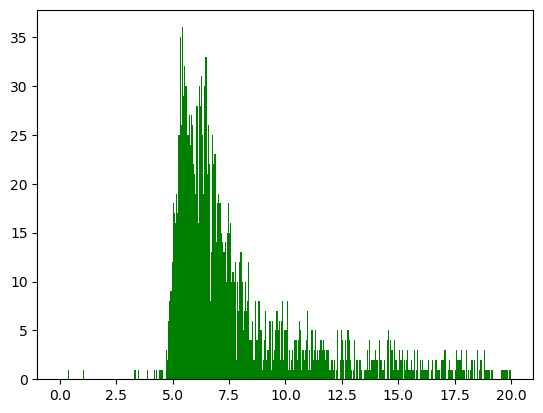

In [67]:
plt.hist(SNR, bins = 400, range = (0,20), color = 'green');

It looks like some outliers are skewing the average.

### How confident are we in these measurements?

In [68]:
sexCat2 = sexCat2.query('5 < SNR_WIN < 1000') # elimiting outliers and setting a minimum SNR

In [69]:
len(sexCat2)

2285

In [70]:
sexCat2['SNR_WIN'].mean()

28.327322975929974

Much more reasonable.

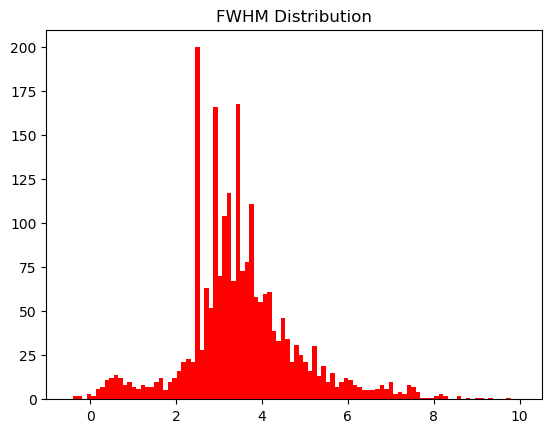

In [71]:
plt.hist(sexCat2['FWHM_IMAGE'], bins = 100, range = (-0.5,10) ,color = 'red')
plt.title('FWHM Distribution');

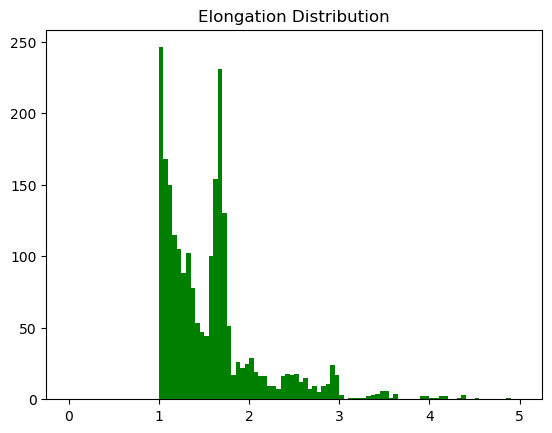

In [72]:
plt.hist(sexCat2['ELONGATION'], bins = 100,range = (0,5), color = 'green')
plt.title('Elongation Distribution');

### Examining the sources that didn't match

In [76]:
len(noMatch)

364

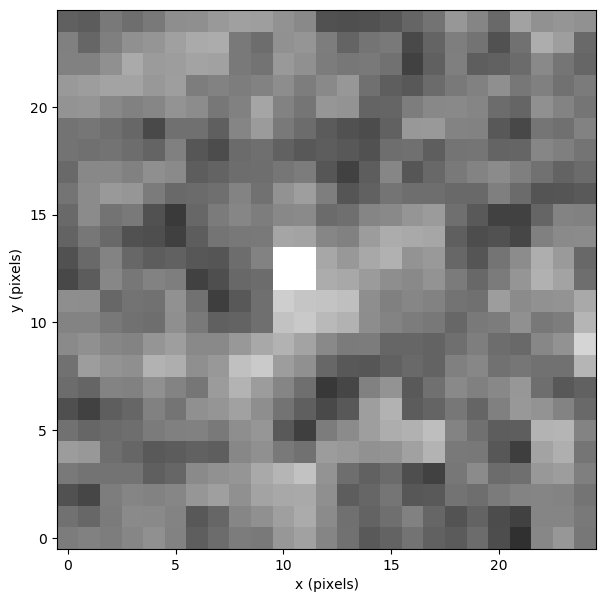

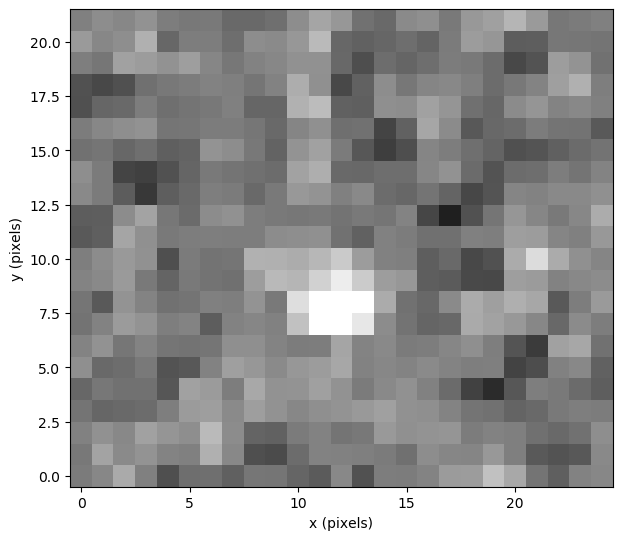

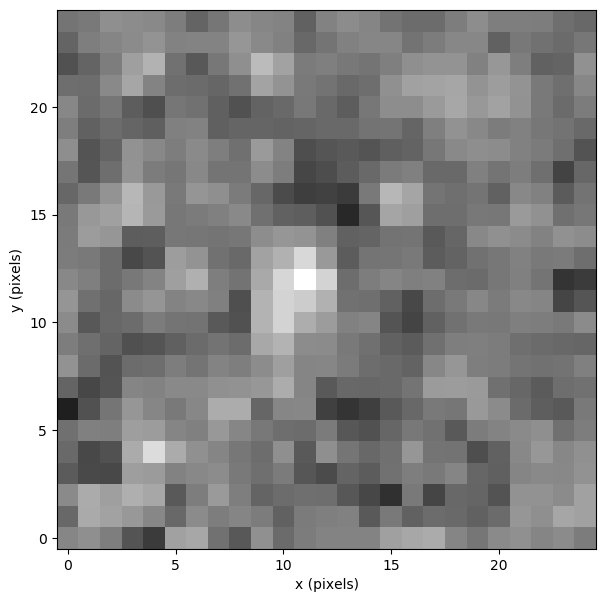

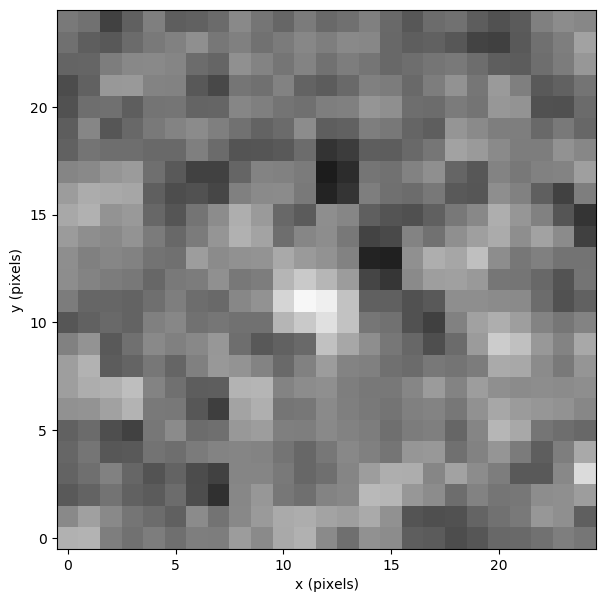

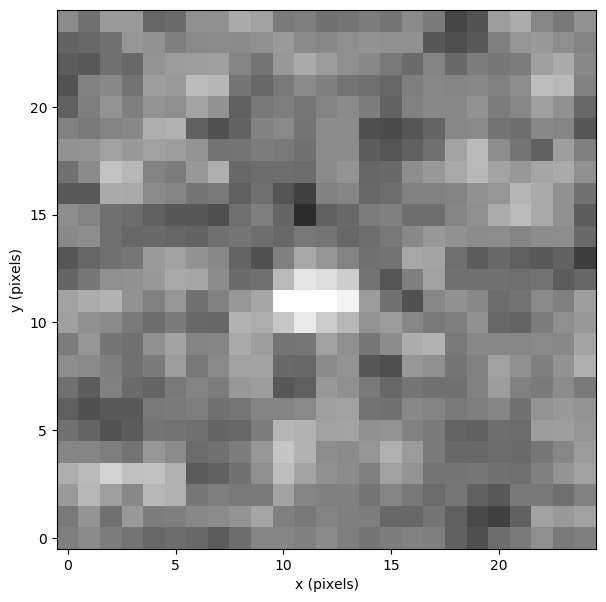

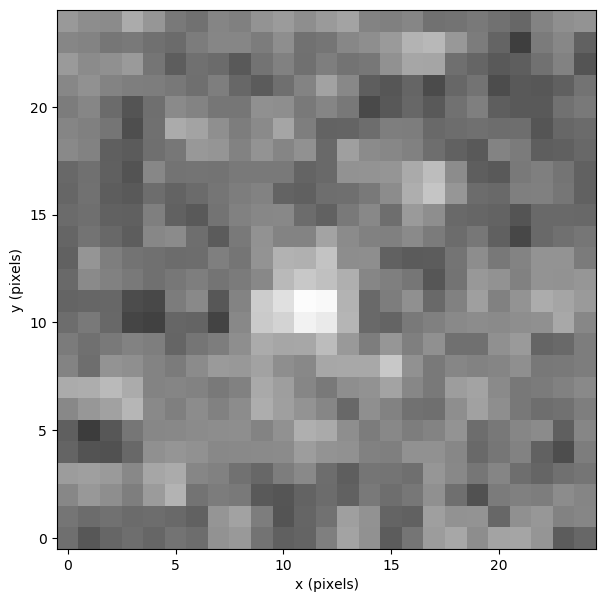

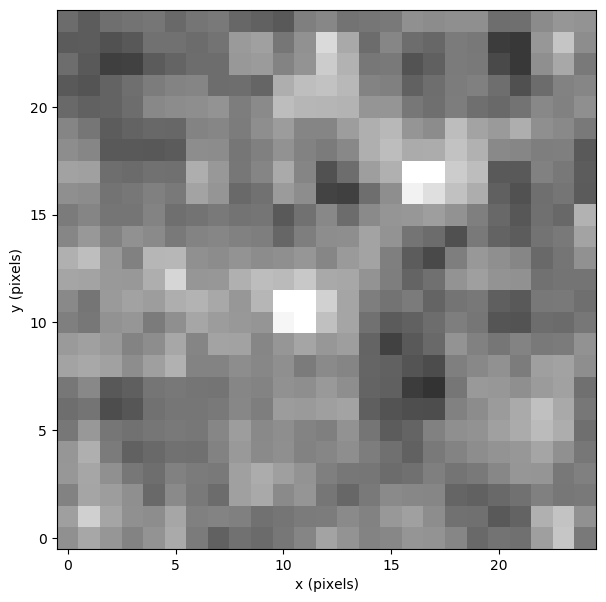

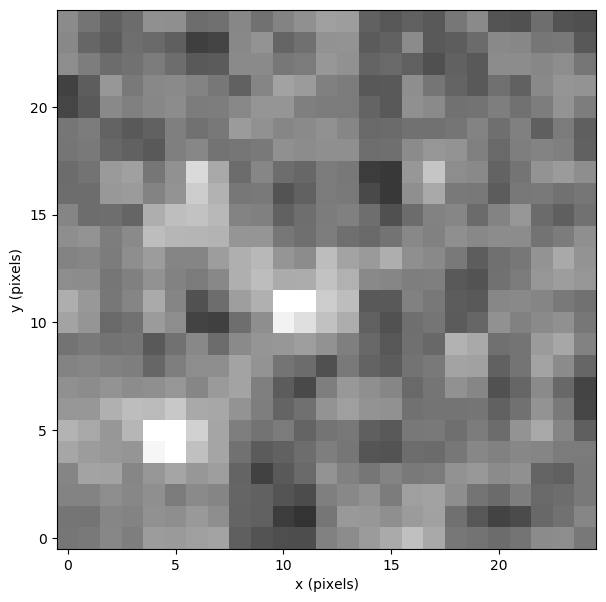

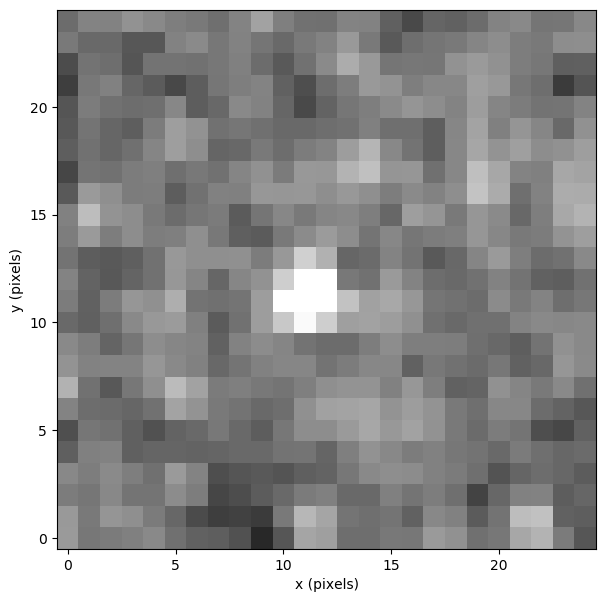

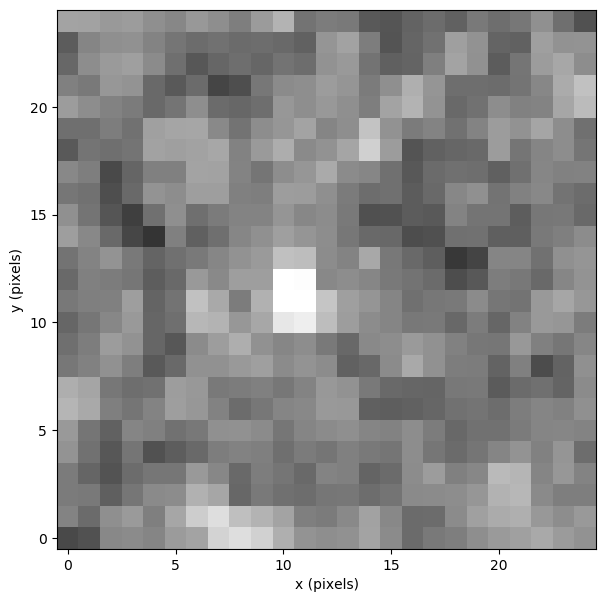

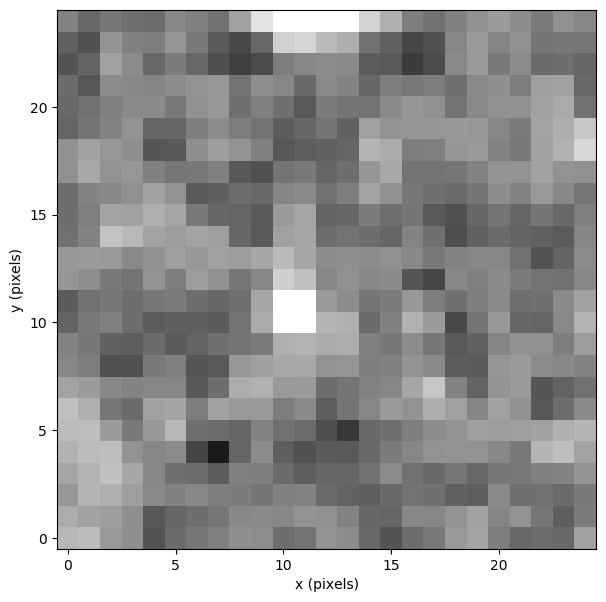

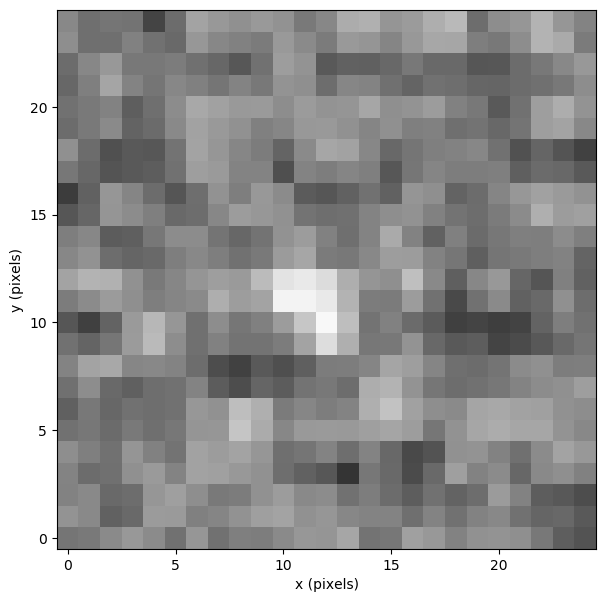

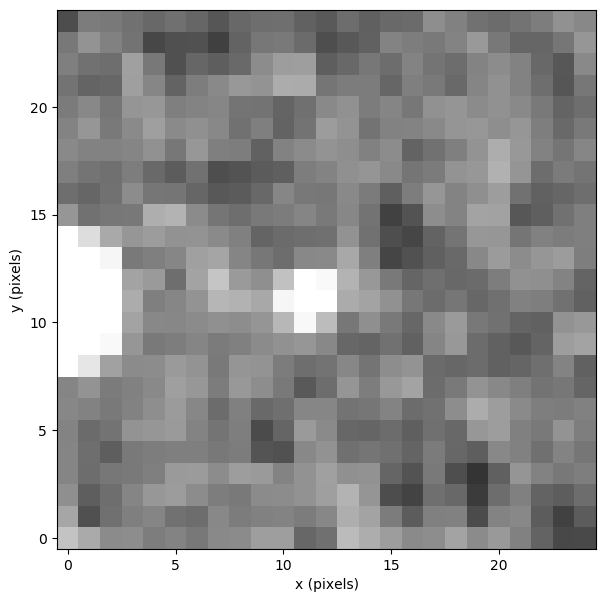

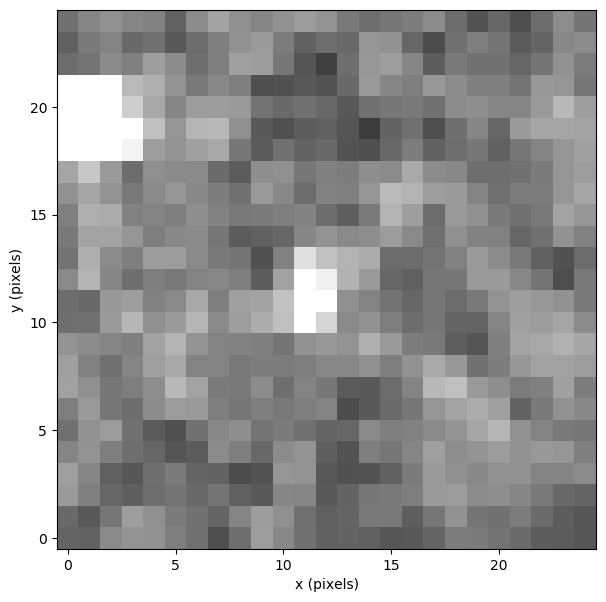

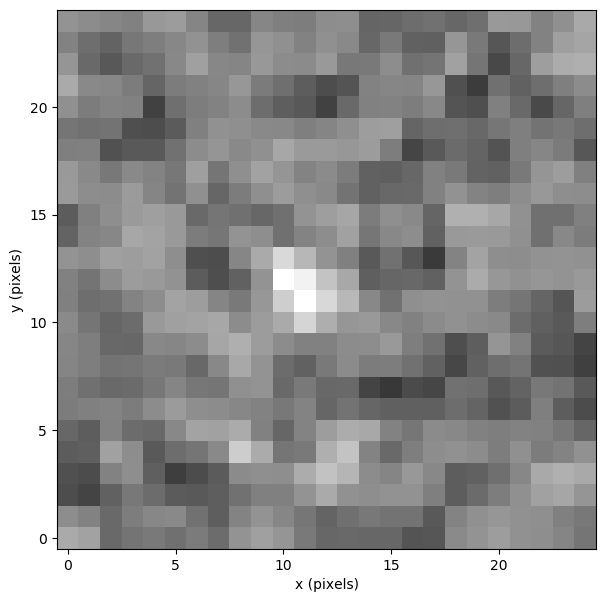

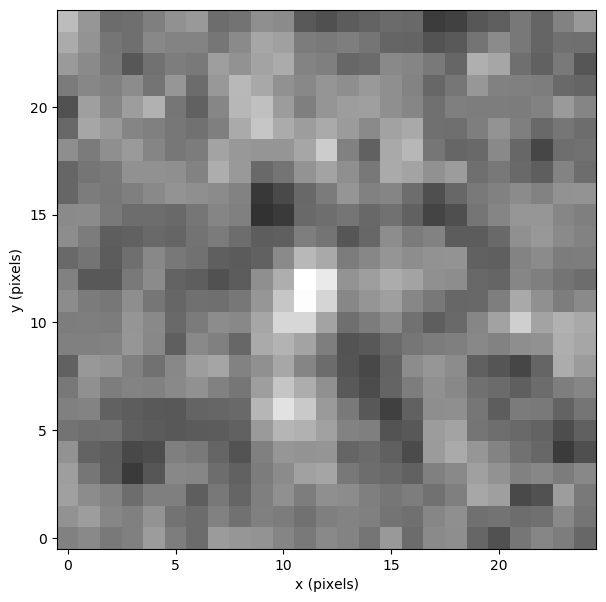

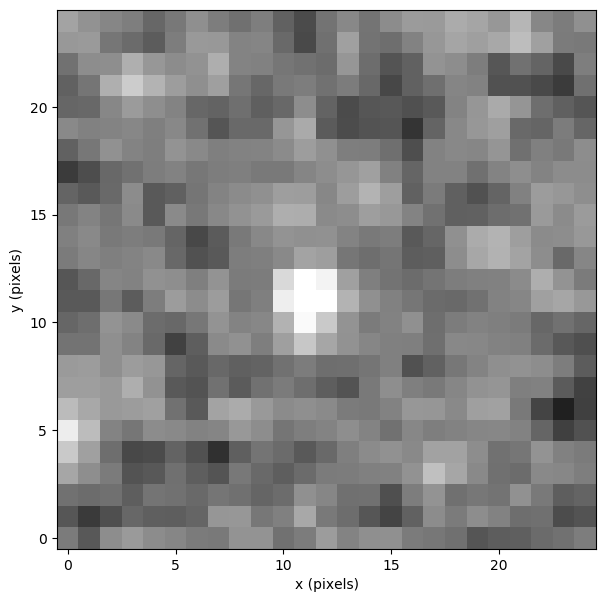

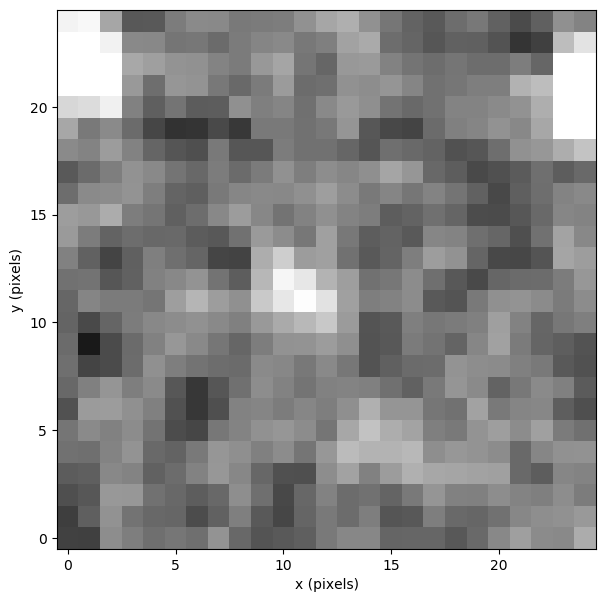

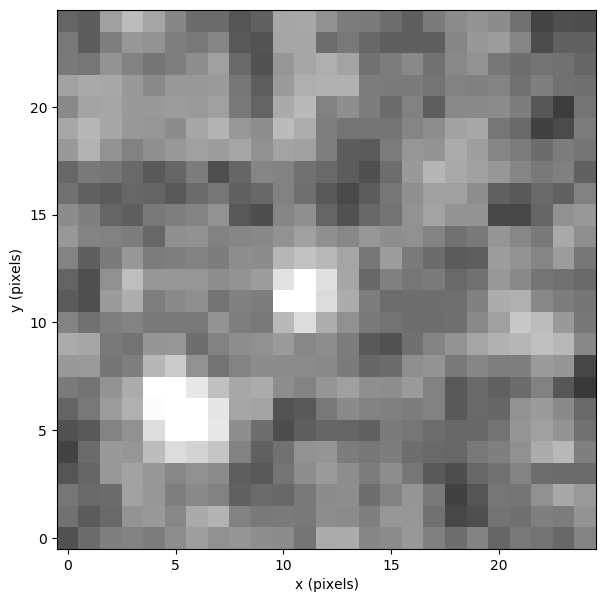

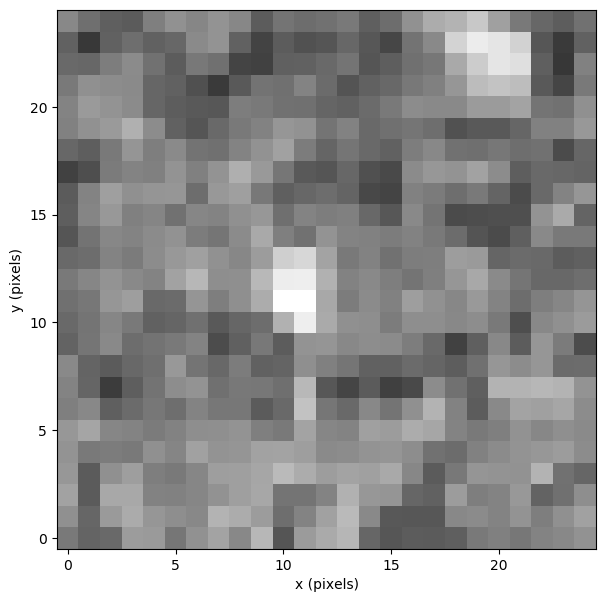

In [92]:
for i in range(0,20):    
    plt.figure(figsize = (7,7))

    position = (noMatch['X_IMAGE'].iloc[i], noMatch['Y_IMAGE'].iloc[i])


    size = (25, 25)     # pixels

    cutout = Cutout2D(imageData, position, size)

    plt.xlabel('x (pixels)')
    plt.ylabel('y (pixels)')

    plt.imshow(cutout.data, origin='lower', cmap = 'gray', vmin = -100, vmax = 100)

In [110]:
noMatch.head()

,index,NUMBER,SNR_WIN,EXT_NUMBER,FLUX_ISO,FLUXERR_ISO,MAG_ISO,MAGERR_ISO,X_IMAGE,Y_IMAGE,ALPHAWIN_J2000,DELTAWIN_J2000,FLAGS,FWHM_IMAGE,ELONGATION
3,4,5,12.46,1,1197.5720,90.81760,-7.6958,0.0824,349.7413,22.3033,219.271310,11.145611,0,8.26,1.870
6,10,11,16.29,1,1555.4680,99.56004,-7.9797,0.0695,846.4716,9.1463,219.263303,11.747273,0,3.89,1.288
9,43,44,10.20,1,660.8122,67.35413,-7.0502,0.1107,862.6879,18.3712,219.275397,11.766379,0,4.66,1.654
11,48,49,10.31,1,688.8749,67.38017,-7.0954,0.1062,364.4968,19.8459,219.267858,11.163006,0,3.76,1.489
12,49,50,14.54,1,1056.9740,76.16312,-7.5602,0.0783,480.2280,16.9587,219.266440,11.303434,0,3.47,1.613


Some outliers at ~310


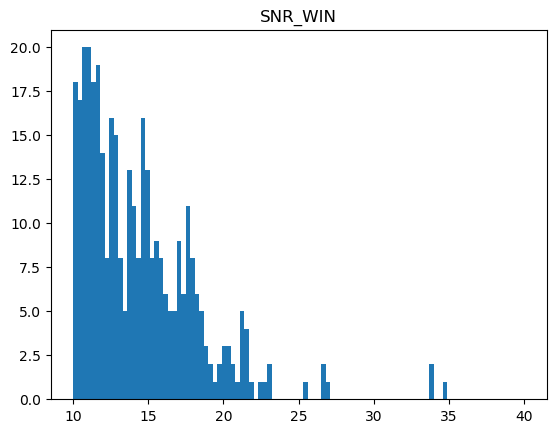

In [113]:
plt.hist(noMatch['SNR_WIN'], range = (10, 40), bins = 100)
plt.title('SNR_WIN')
print('Some outliers at ~310'); 

Some outliers at ~390000


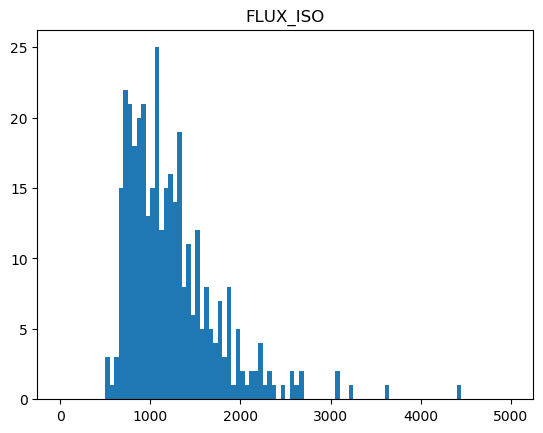

In [114]:
plt.hist(noMatch['FLUX_ISO'], range = (0,5000), bins = 100)
plt.title('FLUX_ISO')
print('Some outliers at ~390000')

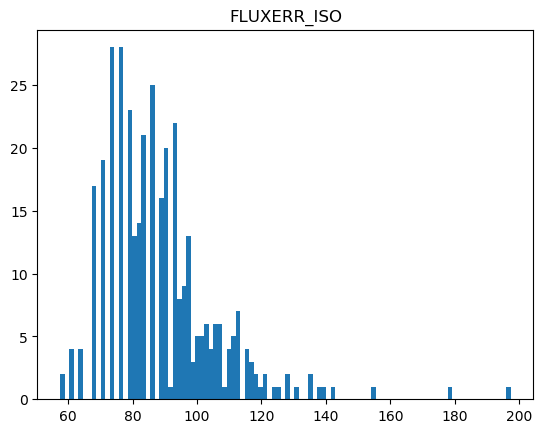

In [115]:
plt.hist(noMatch['FLUXERR_ISO'], bins = 100)
plt.title('FLUXERR_ISO'); 

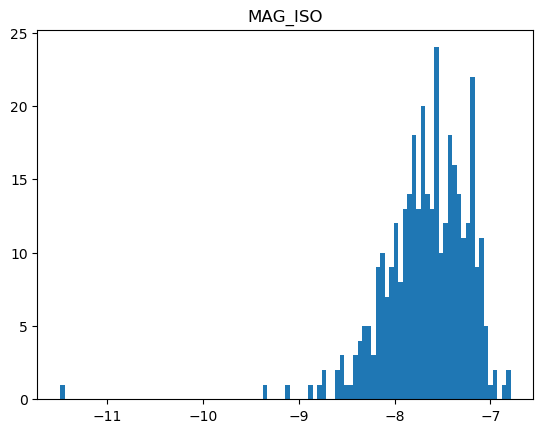

In [116]:
plt.hist(noMatch['MAG_ISO'], bins = 100)
plt.title('MAG_ISO'); 

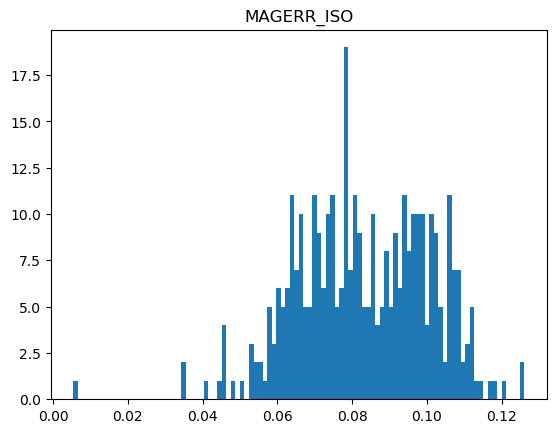

In [117]:
plt.hist(noMatch['MAGERR_ISO'], bins = 100)
plt.title('MAGERR_ISO'); 

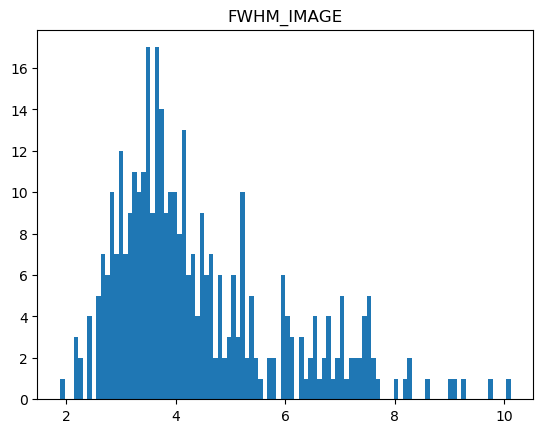

In [118]:
plt.hist(noMatch['FWHM_IMAGE'], bins = 100)
plt.title('FWHM_IMAGE'); 

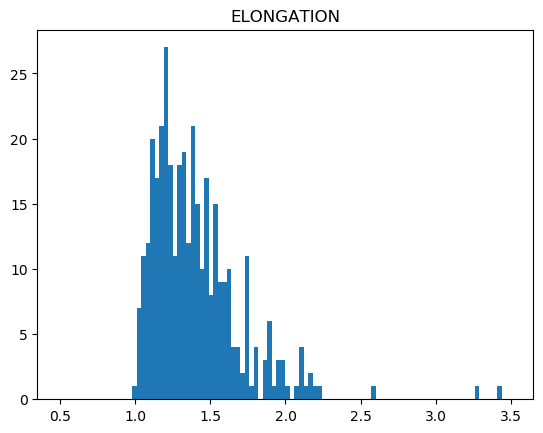

In [121]:
plt.hist(noMatch['ELONGATION'], range = (0.5,3.5), bins = 100)
plt.title('ELONGATION'); 

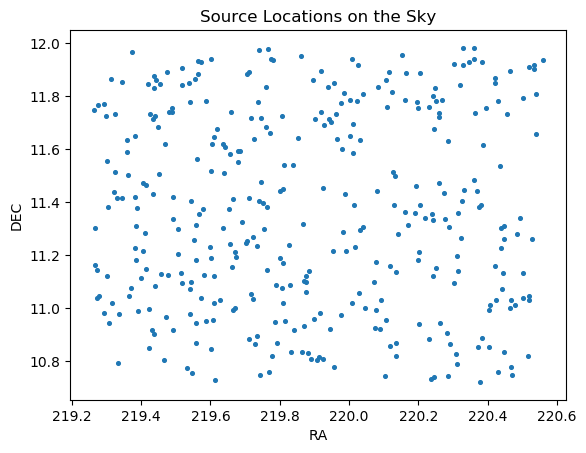

In [129]:
plt.scatter(noMatch['ALPHAWIN_J2000'], noMatch['DELTAWIN_J2000'], s = 7)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Source Locations on the Sky');